In [17]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, Embedding, LSTM, GRU, Conv1D, 
                                   GlobalMaxPooling1D, Bidirectional, Dropout,
                                   Input, MultiHeadAttention, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from utils.helpers import *

In [2]:
print("Loading processed data...")
data = load_processed_data('../../data/processed/processed_data.pkl')

Loading processed data...


In [3]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
label_encoder = data['label_encoder']

In [4]:
# Text Tokenization and Sequencing
print("Tokenizing text data...")
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

Tokenizing text data...


In [5]:
# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Padded sequences shape: {X_train_pad.shape}")

Vocabulary size: 63215
Padded sequences shape: (90157, 100)


In [7]:
# Save tokenizer
save_processed_data(tokenizer, 'tokenizer.pkl')

In [8]:
# CNN for Text Classification
print("Building CNN model...")
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

cnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Building CNN model...


d:\Documents\MCA Course\MCA-Coursework\SEM-3\Deep-Learning\Project\dl-project-venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train CNN Model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=2)

history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 159s 55ms/step - accuracy: 0.7062 - loss: 0.9456 - val_accuracy: 0.7932 - val_loss: 0.6620 - learning_rate: 0.0010
Epoch 2/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 157s 56ms/step - accuracy: 0.8236 - loss: 0.5716 - val_accuracy: 0.8016 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 3/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 156s 55ms/step - accuracy: 0.8717 - loss: 0.4026 - val_accuracy: 0.7986 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 4/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 158s 56ms/step - accuracy: 0.9132 - loss: 0.2679 - val_accuracy: 0.7908 - val_loss: 0.8022 - learning_rate: 0.0010
Epoch 5/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 158s 56ms/step - accuracy: 0.9625 - loss: 0.1174 - val_accuracy: 0.7878 - val_loss: 1.0227 - learning_rate: 2.0000e-04


In [10]:
# LSTM Model
print("Building LSTM model...")
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train LSTM Model
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 339s 118ms/step - accuracy: 0.2840 - loss: 2.1204 - val_accuracy: 0.2853 - val_loss: 2.1051 - learning_rate: 0.0010
Epoch 2/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 334s 119ms/step - accuracy: 0.2853 - loss: 2.1081 - val_accuracy: 0.2853 - val_loss: 2.1050 - learning_rate: 0.0010
Epoch 3/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 342s 121ms/step - accuracy: 0.2853 - loss: 2.1063 - val_accuracy: 0.2853 - val_loss: 2.1048 - learning_rate: 2.0000e-04


In [12]:
# Bidirectional GRU Model
print("Building Bidirectional GRU model...")
bigru_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

bigru_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

bigru_model.summary()

Building Bidirectional GRU model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train BiGRU Model
history_bigru = bigru_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 355s 123ms/step - accuracy: 0.7039 - loss: 0.9681 - val_accuracy: 0.7986 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 2/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 355s 126ms/step - accuracy: 0.8187 - loss: 0.6247 - val_accuracy: 0.8110 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 3/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 343s 122ms/step - accuracy: 0.8501 - loss: 0.5138 - val_accuracy: 0.8103 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 4/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 384s 136ms/step - accuracy: 0.8733 - loss: 0.4266 - val_accuracy: 0.8047 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 5/15
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 355s 126ms/step - accuracy: 0.9165 - loss: 0.2898 - val_accuracy: 0.8029 - val_loss: 0.7753 - learning_rate: 2.0000e-04


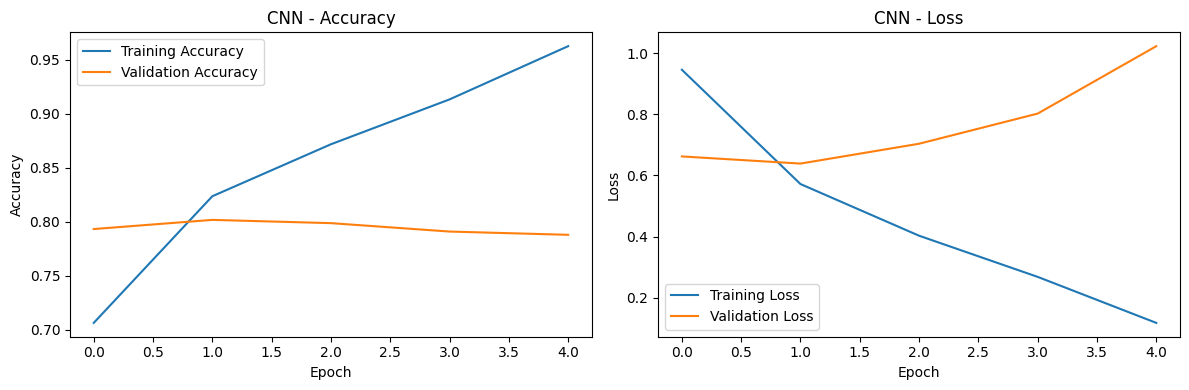

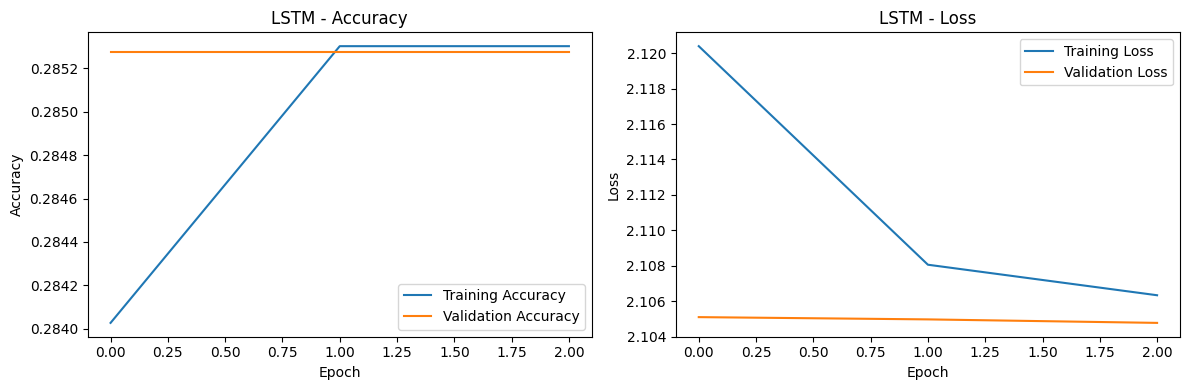

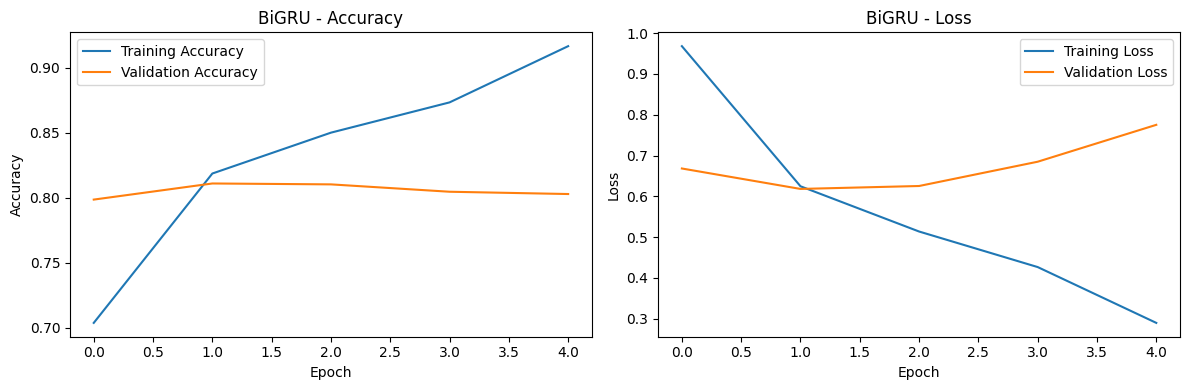

In [14]:
# Plot training histories
def plot_model_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_model_history(history_cnn, "CNN")
plot_model_history(history_lstm, "LSTM")
plot_model_history(history_bigru, "BiGRU")

In [18]:
# Evaluate Advanced Models on Test Set
print("\n=== ADVANCED MODEL COMPARISON ===")

# CNN Evaluation
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_cnn = np.argmax(cnn_model.predict(X_test_pad), axis=1)
cnn_test_f1 = f1_score(y_test, y_pred_cnn, average='weighted')

# LSTM Evaluation
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_lstm = np.argmax(lstm_model.predict(X_test_pad), axis=1)
lstm_test_f1 = f1_score(y_test, y_pred_lstm, average='weighted')

# BiGRU Evaluation
bigru_test_loss, bigru_test_accuracy = bigru_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_bigru = np.argmax(bigru_model.predict(X_test_pad), axis=1)
bigru_test_f1 = f1_score(y_test, y_pred_bigru, average='weighted')

# Results comparison
advanced_results = pd.DataFrame({
    'Model': ['CNN', 'LSTM', 'Bidirectional GRU'],
    'Test Accuracy': [cnn_test_accuracy, lstm_test_accuracy, bigru_test_accuracy],
    'Test F1-Score': [cnn_test_f1, lstm_test_f1, bigru_test_f1]
})

print(advanced_results)


=== ADVANCED MODEL COMPARISON ===
585/585 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step
585/585 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step
               Model  Test Accuracy  Test F1-Score
0                CNN       0.797639       0.791594
1               LSTM       0.285325       0.126677
2  Bidirectional GRU       0.809391       0.804199


In [20]:
# Save Advanced Models
cnn_model.save('../data/models/cnn_text_classifier.h5')
lstm_model.save('../data/models/lstm_text_classifier.h5')
bigru_model.save('../data/models/bigru_text_classifier.h5')

print("Advanced models saved successfully!")

Advanced models saved successfully!
